In [1]:
DEBUG = False

In [2]:
import os
import gc
import cv2
import time
import timm
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import albumentations
from pylab import rcParams
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
from torch.utils.data import  Dataset
import torch.nn.functional as F

%matplotlib inline
rcParams['figure.figsize'] = 20, 8
device = torch.device('cuda')
torch.backends.cudnn.benchmark = True

# Config

In [3]:
kernel_type = '0920_1bonev2_effv2s_224_15_6ch_augv2_mixupp5_drl3_rov1p2_bs8_lr23e5_eta23e6_50ep'
load_kernel = None
load_last = True

n_folds = 5
#backbone = 'tf_efficientnetv2_s.in21k_ft_in1k'
#backbone="tf_efficientnetv2_b3.in21k_ft_in1k"
backbone="tf_efficientnetv2_b0.in1k"

image_size = 296

n_slice_per_c = 28 # all abdomen
in_chans = 4

init_lr = 2.0e-4
eta_min = 0
batch_size = 4
drop_rate = 0.
drop_rate_last = 0.8 #  0.1
drop_path_rate = 0.3
p_mixup = 0.3 #0 0.3
p_rand_order_v1 = 0.2

data_dir = './bowel'
use_amp = True
num_workers = 6
out_dim = 2

n_epochs = 40

log_dir = './logs'
model_dir = './models_bowel'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [4]:
border_mode=cv2.BORDER_CONSTANT
transforms_train = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
    albumentations.HorizontalFlip(p=0.3),
    albumentations.VerticalFlip(p=0.3),
    albumentations.Transpose(p=0.3),
    albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, brightness_by_max=False, always_apply=False, p=0.5),

    #border_mode=cv2.BORDER_REFLECT101
    albumentations.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, border_mode=border_mode, p=0.5),

    albumentations.OneOf([
        albumentations.MotionBlur(blur_limit=3),
        albumentations.MedianBlur(blur_limit=3),
        albumentations.GaussianBlur(blur_limit=(1,3)),
        albumentations.GaussNoise(var_limit=(3.0, 9.0)),
    ], p=0.2),
    albumentations.OneOf([
        albumentations.OpticalDistortion(distort_limit=.3,border_mode=border_mode),
        albumentations.GridDistortion(num_steps=4, distort_limit=.3,border_mode=border_mode),
    ], p=0.5),
    albumentations.Cutout(max_h_size=int(image_size * 0.25), max_w_size=int(image_size * 0.25), num_holes=2, p=0.5),
])

transforms_valid = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
])

/home/sronen/code/.venv/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


# DataFrame

In [5]:
from sklearn.model_selection import KFold

organ_dict = {
    0: 'bowel',
    1: 'extravasation',
}

df_p = pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/train.csv')





df_s=pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/train_series_meta.csv')

df_p['fold'] = -1
kf = KFold(5,shuffle=True,random_state=42)
for fold, (train_idx, valid_idx) in enumerate(kf.split(df_p,df_p)):
    df_p.loc[valid_idx, 'fold'] = fold


#df_healthy=df_p[df_p["any_injury"]==0].sample(758)
#df_injured=df_p[(df_p["kidney_healthy"]==0) | (df_p["liver_healthy"]==0)| (df_p["spleen_healthy"]==0) | (df_p["bowel_healthy"]==0)]
#print(len(df_injured),len(df_healthy))
#df_p1=pd.concat((df_healthy,df_injured))


df=df_p.merge(df_s,on="patient_id")
df["count"]=df.groupby(["patient_id"])["patient_id"].transform("count")


pid=[]
sid = []
cs = []
label = []
fold = []
hu=[]
counts=[]
lbowel=[]
lextra=[]
for row in df.to_dict(orient="records"):
        pid.append(row["patient_id"])
        sid.append(row["series_id"])
        hu.append(row["aortic_hu"])
        la=[row["bowel_injury"],row["extravasation_injury"]]
        label.append(la)
        lbowel.append(la[0])
        lextra.append(la[1])
        fold.append(row["fold"])
        counts.append(row["count"])

df = pd.DataFrame({
    'patient_id': pid,
    'series_id': sid,
    'hu':hu,
    'label': label,
    'bowel':lbowel,
    "extravasation":lextra,
    'fold': fold,
    'counts':counts,
})

#pd.set_option('display.max_rows', None)
df = df.sample(16).reset_index(drop=True) if DEBUG else df
#df_image=pd.read_csv("/kaggle/input/rsna-2023-abdominal-trauma-detection/image_level_labels.csv")
#df_image=df_image.groupby(["patient_id","series_id"]).injury_name.value_counts().unstack(fill_value=0)
#df_image=(df_image>0).reset_index()
#print(df_image.head(100))
df.to_csv("df_stage2b.csv")
len(df)


4711

In [6]:
print(len(df_p),len(df_s))


3147 4711


# Dataset

In [7]:
class CLSDataset(Dataset):
    def __init__(self, df, mode, transform):

        self.df = df.reset_index()
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        images = []
        
        filepath=os.path.join(data_dir, f'{row.patient_id}_{row.series_id}.npz')
        data = np.load(filepath)
        image3d=data['arr_0'] # slice,channel,H,W

        if self.mode=="train":    
            select_ind = np.random.choice(list(range(image3d.shape[0])),n_slice_per_c,replace=False)
        else:
            # select_ind = np.random.choice(list(range(image3d.shape[0])),100,replace=False)
            select_ind=list(range(image3d.shape[0]))

        #for ind in list(range(n_slice_per_c)):
        for ind in select_ind:
            image=image3d[ind,...].transpose(1,2,0).astype(np.uint8)
            image = self.transform(image=image)['image']
            image = image.transpose(2, 0, 1).astype(np.float32) / 255.
            images.append(image)
        images = np.stack(images, 0)

   

        if self.mode != 'test':
            images = torch.tensor(images).float()
            labels=data['arr_1'][select_ind]  # slice
            labels = torch.tensor(labels).float()
            counts=torch.tensor([row.counts]*n_slice_per_c).float()
            
            #images[...]=0.
            #images[:,:,:,:3]=labels[:,None,None,:]
            #images[:,0,0,:3]=labels[:,:]

         
            
            if self.mode == 'train' and random.random() < p_rand_order_v1:
                indices = torch.randperm(images.size(0))
                images = images[indices]
                counts=counts[indices]

            return images, labels,counts
        else:
            return torch.tensor(images).float()

In [8]:
rcParams['figure.figsize'] = 20,8

df_show = df
dataset_show = CLSDataset(df_show, 'train', transform=transforms_train)
loader_show = torch.utils.data.DataLoader(dataset_show, batch_size=batch_size, shuffle=True, num_workers=num_workers)

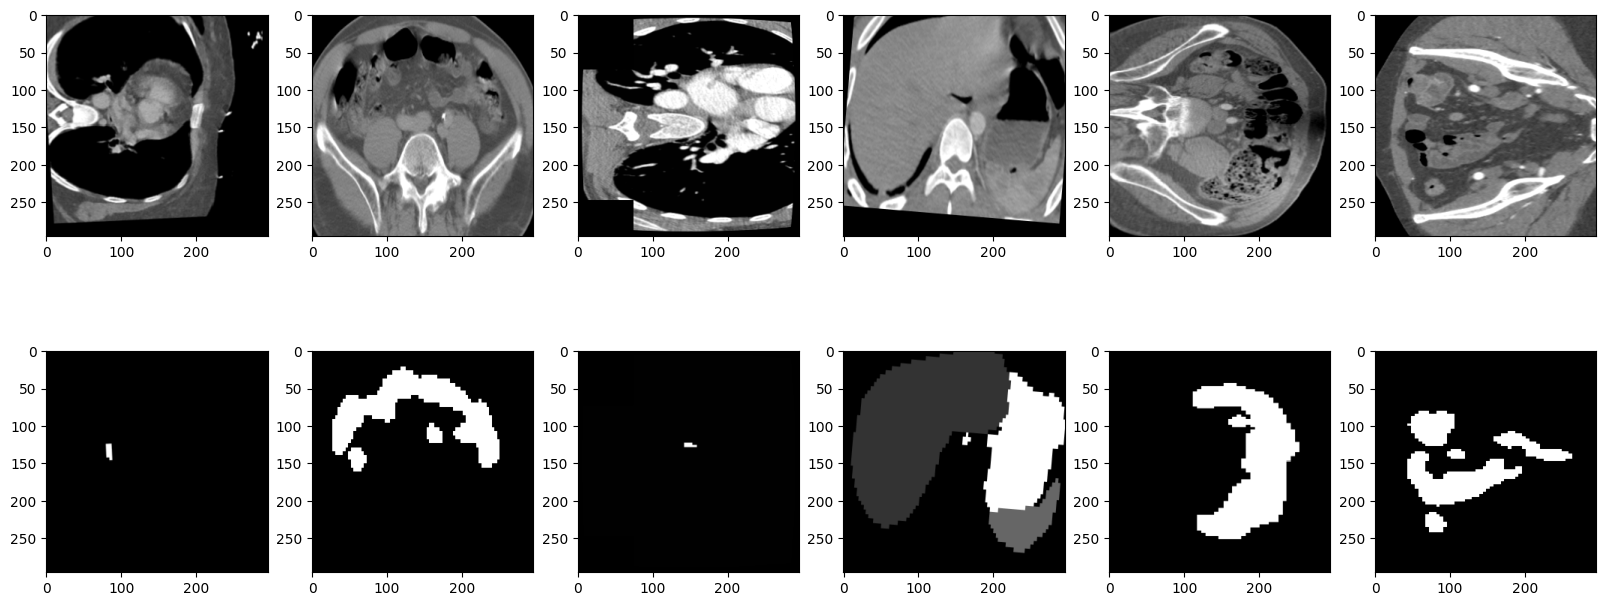

In [9]:
f, axarr = plt.subplots(2,6)
for p in range(6):
    idx = p * 20
    imgs, lbl,_ = dataset_show[idx]
    sel=7
    axarr[0, p].imshow(255*imgs[sel][1],cmap="gray")
    axarr[1, p].imshow(imgs[sel][-1],cmap="gray")

# Model

In [10]:
class TimmModel(nn.Module):
    def __init__(self, backbone, pretrained=False,features=False):
        super(TimmModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=in_chans,
            num_classes=out_dim,
            features_only=False,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()

        self.head = nn.Linear(1280, out_dim)
        self.features=features

    def forward(self, x):  # (bs, nslice, ch, sz, sz)
        bs = x.shape[0]
        x = x.view(-1, in_chans, image_size, image_size)
        feat = self.encoder(x)
        if self.features:
            return feat
        
        logits = self.head(feat)
        logits=logits.view(bs,-1,out_dim)
        return logits

In [11]:
from torchinfo import summary
#summary(m,(1,n_slice_per_c,in_chans,image_size,image_size))
m = TimmModel(backbone)

print(summary(m,(2,n_slice_per_c,in_chans,image_size,image_size)))
#dummy=torch.rand((2,30,in_chans,image_size,image_size)).float().cuda()
#m=m.cuda()
#m(dummy).shape

Layer (type:depth-idx)                             Output Shape              Param #
TimmModel                                          [2, 28, 2]                --
├─EfficientNet: 1-1                                [56, 1280]                --
│    └─Conv2dSame: 2-1                             [56, 32, 148, 148]        1,152
│    └─BatchNormAct2d: 2-2                         [56, 32, 148, 148]        64
│    │    └─Identity: 3-1                          [56, 32, 148, 148]        --
│    │    └─SiLU: 3-2                              [56, 32, 148, 148]        --
│    └─Sequential: 2-3                             [56, 192, 10, 10]         --
│    │    └─Sequential: 3-3                        [56, 16, 148, 148]        4,640
│    │    └─Sequential: 3-4                        [56, 32, 74, 74]          52,736
│    │    └─Sequential: 3-5                        [56, 48, 37, 37]          136,000
│    │    └─Sequential: 3-6                        [56, 96, 19, 19]          230,652
│    │    └─Seq

In [12]:
bce = nn.BCEWithLogitsLoss(reduction='none')
def criterion(logits, targets,use_weights=False):
    logits=logits.view(-1,out_dim)
    targets=targets.view(-1,out_dim)
    w1=targets[:,0]+1.
    w2=targets[:,1]*5+1.
    w=torch.stack((w1,w2),dim=1)
    loss = bce(logits, targets)
    if use_weights:
        return loss,w
    else:
        loss=torch.mean(torch.mean(loss*w,dim=0))
        return loss

In [13]:
from torch.distributions.beta import Beta
beta=Beta(torch.tensor([0.2]),torch.tensor([0.2]))

def mix_up(images1,labels1):
    # Unpack two datasets
    batch_size = images1.shape[0]
    # Sample lambda and reshape it to do the mixup
    l = beta.sample(torch.Size([batch_size])).cuda()
    x_l = l.reshape((batch_size, 1, 1, 1,1))
    y_l = l.reshape((batch_size, 1,1))
    idx = torch.randperm(batch_size).cuda()
    images2=images1[idx,...]
    labels2=labels1[idx,...]
    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images1 * x_l + images2 * (1 - x_l)
    labels = labels1 * y_l + labels2 * (1 - y_l)
    return (images, labels)


def train_func(model, loader_train, optimizer, scaler=None):
    model.train()
    train_loss = []
    bar = tqdm(loader_train)
    for images, targets,_ in bar:
        optimizer.zero_grad()
        images = images.cuda()
        targets = targets.cuda()
  
        if random.random() < p_mixup:
            images, targets = mix_up(images, targets)

        if use_amp:
            with amp.autocast():
                logits = model(images)
                loss = criterion(logits, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss.append(loss.item())

        else:
            logits = model(images)
            loss= criterion(logits, targets)
            
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

            
        bar.set_description(f'smth:{np.mean(train_loss[-100:]):.4f}')

    return np.mean(train_loss)


def valid_func(model, loader_valid,dff):
    model.eval()
    valid_loss=[]
    wa=[]
    bar = tqdm(loader_valid)
    with torch.no_grad():
        for images, targets,counts in bar:
            images = images.cuda()
            targets = targets.cuda()
            counts=counts.cuda()

            if use_amp:
                with amp.autocast():
                    logits = model(images)
                    loss,w=criterion(logits,targets,use_weights=True)
            else:
                logits = model(images)
                loss,w=criterion(logits,targets,use_weights=True)

            valid_loss.append(loss.cpu())
            wa.append(w.cpu())

            v1=np.concatenate(valid_loss[-100:])
            w1=np.concatenate(wa[-100:])
            smth=np.mean(np.average(v1,weights=w1,axis=0))
            bar.set_description(f'smth:{smth:.4f}')


    v1=np.concatenate(valid_loss)
    w1=np.concatenate(wa)
    valid_loss=np.mean(np.average(v1,weights=w1,axis=0))                
    return valid_loss
            

/home/sronen/code/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/home/sronen/code/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate yo

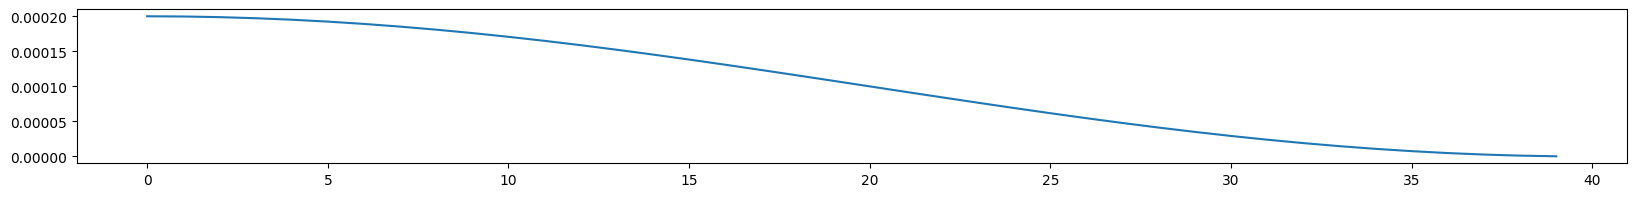

In [14]:
rcParams['figure.figsize'] = 20, 2
optimizer = optim.AdamW(m.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs, eta_min=eta_min)

lrs = []
for epoch in range(1, n_epochs+1):
    scheduler_cosine.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
plt.plot(range(len(lrs)), lrs)



In [15]:
df.label.value_counts()

label
[0, 0]    4338
[0, 1]     269
[1, 0]      73
[1, 1]      31
Name: count, dtype: int64

In [16]:
del m,optimizer
torch.cuda.empty_cache()
gc.collect()

35

# Training

In [17]:
from torch.utils.data import WeightedRandomSampler
def run(fold):

    log_file = os.path.join(log_dir, f'{kernel_type}.txt')
    model_file = os.path.join(model_dir, f'{kernel_type}_fold{fold}_best.pth')

    #train_ = df[df['fold'] != fold].reset_index(drop=True)

    train_ = df[(df['fold'] != fold) & ((df["bowel"]>0) | (df["extravasation"]>0)) ].reset_index(drop=True)
    valid_ = df[(df['fold'] == fold) & ((df["bowel"]>0) | (df["extravasation"]>0)) ].reset_index(drop=True)

    

    dataset_train = CLSDataset(train_, 'train', transform=transforms_train)
    dataset_valid = CLSDataset(valid_, 'valid', transform=transforms_valid)
    

    class_counts = train_.label.value_counts()
    print("class_counts",class_counts)

    class_w_bowel=[1,12]
    class_w_extravasation=[1,12]
    bowel_weights=[class_w_bowel[i] for i in train_.bowel.values]
    extravasation_weights=[class_w_extravasation[i] for i in train_.extravasation.values]
    sample_train_weights=[max(bowel_weights[i],extravasation_weights[i]) for i in range(len(train_))]
    sample_train_weights=[sample_train_weights[i]/train_.counts.values[i] for i in range(len(train_))]

    nsamp=500
    sampler=WeightedRandomSampler(weights=sample_train_weights,num_samples=nsamp)

    
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
    #loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, num_workers=num_workers, drop_last=True,sampler=sampler)

    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=4, shuffle=False, num_workers=num_workers)

    model = TimmModel(backbone, pretrained=True)
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=init_lr,weight_decay=1e-4)
    scaler = torch.cuda.amp.GradScaler() if use_amp else None

    metric_best = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, n_epochs, eta_min=eta_min)

    print("#train", len(dataset_train), "#valid",len(dataset_valid))

    for epoch in range(1, n_epochs+1):
        print(time.ctime(), 'Epoch:', epoch)
        train_loss = train_func(model, loader_train, optimizer, scaler)
        scheduler_cosine.step(epoch-1)   
        valid_loss = valid_func(model, loader_valid,valid_)
    
        metric = valid_loss

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, metric: {(metric):.6f}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric < metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
#             if not DEBUG:
            torch.save(model.state_dict(), model_file)
            metric_best = metric

        # Save Last
        if not DEBUG:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'score_best': metric_best,
                },
                model_file.replace('_best', '_last')
            )

    del model
    torch.cuda.empty_cache()
    gc.collect()

In [18]:
TRAINING=False
if TRAINING:
    run(0)
    run(1)
    run(2)
    run(3)
    run(4)

# Save features

In [19]:
def infer_features(ifold):
    print(ifold)
    model = TimmModel(backbone, pretrained=False,features=True)
    model_file = os.path.join(model_dir, f'{kernel_type}_fold{ifold}_best.pth')
    model.load_state_dict(torch.load(model_file))
    model = model.to(device)

    dataset = CLSDataset(df, 'test', transform=transforms_valid) 
    save_path=f"features/model{ifold}"           
    os.makedirs(save_path,exist_ok=True)
    for ind,row in tqdm(df.iterrows()):
        images = dataset[ind]
        with torch.no_grad():
            images=images.cuda()
            images=images[None,...]
            features = model(images).squeeze()
            features=features.numpy(force=True)
        np.save(f"{save_path}/{row.patient_id}_{row.series_id}",features)
    
    del model
    torch.cuda.empty_cache()
    gc.collect()
    
PREP_FEATURES=True
if PREP_FEATURES:
    for i in range(5):
        infer_features(i)

0
0 10005 18667
1 10007 47578
2 10026 29700
3 10026 42932
4 10051 17486
5 10051 50172
6 10065 37324
7 10065 46839
8 10082 8139
9 10104 27573
10 10105 42418
11 10124 58500
12 10127 1554
13 10127 53380
14 10132 4816
15 10163 17557
16 10169 18334
17 10205 65236
18 10217 16066
19 10232 14541
20 10232 51162
21 10249 2346
22 10249 60095
23 1027 24515
24 1027 60982
25 10275 14254
26 10275 37142
27 10295 10410
28 10300 31085
29 10443 15679
30 10443 4991
31 10465 4405
32 10465 48503
33 10494 65369
34 10557 59654
35 10565 16281
36 10569 26870
37 10569 29394
38 1060 29529
39 10683 14324
40 10683 3716
41 10696 62306
42 10697 27005
43 10697 59033
44 10721 48437
45 10721 63796
46 10722 46573
47 10722 50314
48 10730 15721
49 10814 56132
50 10852 37069
51 10925 54600
52 10929 34169
53 10981 53877
54 10987 5611
55 11021 58443
56 11044 37630
57 11046 19484
58 11046 29137
59 11130 8511
60 11139 24201
61 11139 31481
62 11177 13041
63 11177 29167
64 11217 48987
65 11217 54368
66 11301 2703
67 11301 57412
6

KeyboardInterrupt: 